## Treinando minha rede neural de detecção de meteoros

Olá pessoal, gostaria de compartilhar com vocês o algoritmo que tenho desenvolvido para treinar minha rede neural de detecção de meteoros. Embora não seja um algoritmo absurdamente sofisticado, ele me permite estudar um pouco mais sobre alguns algoritmos de inteligência artificial enquanto pratico meu hobby.

Neste artigo, apresentarei a abordagem que estou seguindo para a preparação dos dados e para o treinamento efetivo da rede. Basicamente, o algoritmo funciona da seguinte forma: apresento uma imagem a ele e ele a classifica em uma das quatro categorias: empty_sky, horizon, sky_with_clouds e sky_with_meteor. Vamos lá!?

### Etapa 1 - Preparando o conjunto de treinamento
A parte mais desafiadora de todo o processo é obter os dados e separá-los em categorias diferentes. Tenho uma câmera que grava durante toda a noite, gerando cerca de 1,5 a 2GB de dados por noite. Para utilizar esses dados no algoritmo que desenvolvi, é necessário pré-processá-los e convertê-los para um formato adequado.

Nesta etapa de processamento, utilizo o algoritmo [png-seq-creator](https://github.com/isakruas/vega/tree/master/apps/png-seq-creator) para gerar uma sequência de imagens, cada uma correspondendo à compressão de 30 segundos de vídeo. Em seguida, utilizo o algoritmo [gs-img-cropper](https://github.com/isakruas/vega/tree/master/apps/gs-img-cropper) para separar cada uma dessas imagens em 70 regiões distintas.

A parte mais desafiadora é rotular cada um dos 70 fragmentos gerados em cada imagem em uma das categorias desejadas: empty_sky, horizon, sky_with_clouds ou sky_with_meteor. Imagem por imagem, observo e movo para a pasta correspondente.

Após essa etapa, o processo se torna mais divertido e animador!

### Etapa 2 - Definindo o modelo de rede neural escolhido

Certamente, existem vários modelos de rede neural capazes de solucionar o problema abordado, que é a classificação de imagens. Portanto, peço desculpas se a abordagem que escolhi não é a mais recomendada ou eficiente. No entanto, decidi segui-la porque estava interessado em resolver o problema dessa forma.

Minha ideia é criar uma rede neural autoencoder. Li que, para tarefas de classificação de imagem, esses modelos podem ajudar a extrair características relevantes das imagens e melhorar a precisão, o que, em minha percepção, se aplica ao meu caso. Como nem todas as imagens que tenho rotuladas são de extrema qualidade, um modelo como este pode me ajudar a extrair as características fundamentais de cada imagem e, assim, possibilitar identificar imagens semelhantes.

#### Bibliotecas necessárias para construir o algoritmo
Para construir e testar o algoritmo mencionado, vamos precisar das bibliotecas Python:

* torch==2.0.0
* torchvision==0.15.1
* matplotlib

Além dessas, vamos utilizar outras bibliotecas complementares, que serão mencionadas ao longo do texto.
#### Implementação do algoritmo
Para implementar o algoritmo, primeiro precisamos carregar as bibliotecas necessárias:

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

Definir transformações para pré-processamento das imagens

In [2]:
transform = transforms.Compose([
    transforms.Grayscale(), # imagem em escala de cinza
    transforms.Resize((28, 28)), # redimenciona a imagem para 28x28px
    transforms.ToTensor(), # converte para tensor do torch
])

Carregar o dataset a partir do diretório 'classes'

In [3]:
dataset = datasets.ImageFolder('./classes/', transform=transform)

Dividir o dataset em conjuntos de treinamento e teste

In [4]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

Definir os dataloaders para carregar os dados

In [5]:
batch_size = 112
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

E, finalmente, definir o modelo CAE

In [6]:
# CAE (Convolutional Autoencoder)
class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1), # convolução 2D com 32 filtros de tamanho 3x3
            nn.ReLU(), # ativação ReLU
            nn.MaxPool2d(kernel_size=2, stride=2), # pooling máximo de tamanho 2x2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # convolução 2D com 64 filtros de tamanho 3x3
            nn.ReLU(), # ativação ReLU
            nn.MaxPool2d(kernel_size=2, stride=2), # pooling máximo de tamanho 2x2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1), # convolução 2D com 128 filtros de tamanho 3x3
            nn.ReLU(), # ativação ReLU
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1), # transposição da convolução 2D com 128 filtros de tamanho 3x3
            nn.ReLU(), # ativação ReLU
            nn.Upsample(scale_factor=2), # upsampling por um fator de 2
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1), # transposição da convolução 2D com 64 filtros de tamanho 3x3
            nn.ReLU(), # ativação ReLU
            nn.Upsample(scale_factor=2), # upsampling por um fator de 2
            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1), # transposição da convolução 2D com 1 filtro de tamanho 3x3
        )
    
    def forward(self, x):
        
        # Codificação
        x = self.encoder(x)
        
        # Decodificação
        x = self.decoder(x)

        return x

In [7]:
# Se estiver usando uma GPU CUDA

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_cae = CAE()
model_cae = model_cae.to(device)
model_cae

CAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Upsample(scale_factor=2.0, mode='nearest')
    (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Upsample(scale_factor=2.0, mode='nearest')
    (6): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

Então vamos montar o algoritmo de treinamento para este modelo :)

### Etapa 3 - Treinamento o modelo CAE

Nesta etapa de treinamento, seguiremos o padrão convencional. Não há nada de especial em relação ao que já é conhecido pelos que estão familiarizados com este processo. Resumidamente, alimentaremos cada imagem no modelo, calcularemos o erro e ajustaremos os pesos. No entanto, faremos isso de uma maneira muito agradável, usando a biblioteca Torch. Iremos treinar este modelo por 200 épocas.

Definindo a função de perda e otimizador

In [8]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_cae.parameters(), lr=0.0001)

In [9]:
num_epochs = 200

for epoch in range(num_epochs):
    epoch_loss = []
    for batch in train_loader:
        feature, label = batch
        feature = feature.to(device)
        
        # Forward pass
        recon = model_cae(feature)
        loss = criterion(recon, feature)
        epoch_loss.append(loss.detach().item())
        
        # Backward pass e otimização
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    epoch_loss = np.array(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss.mean():.4f}")

Epoch [1/200], Loss: 0.3817
Epoch [2/200], Loss: 0.0861
Epoch [3/200], Loss: 0.0521
Epoch [4/200], Loss: 0.0375
Epoch [5/200], Loss: 0.0264
Epoch [6/200], Loss: 0.0182
Epoch [7/200], Loss: 0.0120
Epoch [8/200], Loss: 0.0079
Epoch [9/200], Loss: 0.0057
Epoch [10/200], Loss: 0.0047
Epoch [11/200], Loss: 0.0041
Epoch [12/200], Loss: 0.0037
Epoch [13/200], Loss: 0.0034
Epoch [14/200], Loss: 0.0032
Epoch [15/200], Loss: 0.0029
Epoch [16/200], Loss: 0.0028
Epoch [17/200], Loss: 0.0026
Epoch [18/200], Loss: 0.0024
Epoch [19/200], Loss: 0.0022
Epoch [20/200], Loss: 0.0021
Epoch [21/200], Loss: 0.0020
Epoch [22/200], Loss: 0.0018
Epoch [23/200], Loss: 0.0017
Epoch [24/200], Loss: 0.0016
Epoch [25/200], Loss: 0.0016
Epoch [26/200], Loss: 0.0015
Epoch [27/200], Loss: 0.0014
Epoch [28/200], Loss: 0.0013
Epoch [29/200], Loss: 0.0013
Epoch [30/200], Loss: 0.0012
Epoch [31/200], Loss: 0.0012
Epoch [32/200], Loss: 0.0012
Epoch [33/200], Loss: 0.0011
Epoch [34/200], Loss: 0.0011
Epoch [35/200], Loss: 0

É importante notar que, considerando a quantidade de dados que possuímos, treinar o modelo por 200 épocas pode ser um exagero. Portanto, fique à vontade para experimentar diferentes quantidades de épocas e encontrar a melhor opção para o nosso conjunto de dados

### Etapa 4 - Testando o modelo CAE 


Vamos dar uma olhada no resultado do modelo, para verificar se ele consegue reconstruir as imagens conforme o esperado.

In [10]:
test_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

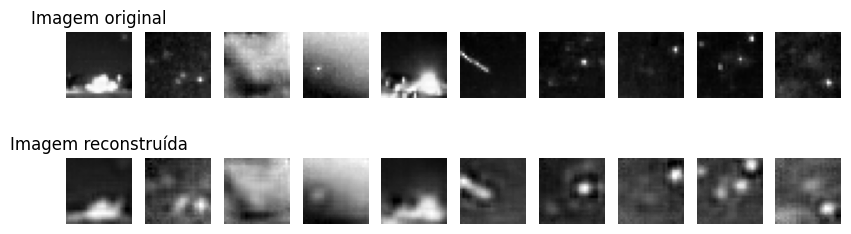

In [11]:
with torch.no_grad():
    for data in test_loader:
        img, _ = data
        img = img.to(device)
        
        # Reconstruir imagem
        recon = model_cae(img)
        
        img = img.cpu().detach().numpy()
        recon = recon.cpu().detach().numpy()
        
        # Exibir imagem original e reconstruída
        plt.figure(figsize=(10, 3))
        for i in range(10):
            # Imagem original
            plt.subplot(2, 10, i+1)
            plt.imshow(img[i, 0], cmap='gray')
            if i ==0:
                 plt.title('Imagem original')
            plt.axis('off')
            
            # Imagem reconstruída
            plt.subplot(2, 10, i+11)
            plt.imshow(recon[i, 0], cmap='gray')
            if i ==0:
                 plt.title('Imagem reconstruída')
            plt.axis('off')
        plt.show()
        break

Observe que o modelo está reconstruindo bem as imagens, o que é ótimo, significa que podemos passar para a próxima etapa!

### Etapa 5 - Definindo modelo MLP

Iremos definir um modelo MLP para realizar a classificação dos dados que serão retornados pelo CAE. Embora possam existir outras abordagens possíveis e talvez mais interessantes, optei por seguir esse caminho no momento.

In [12]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(28 * 28, 128), # camada linear com 128 neurônios
            nn.ReLU(), # ativação ReLU
            nn.Linear(128, 64), # camada linear com 64 neurônios
            nn.ReLU(), # ativação ReLU
            nn.Linear(64, 4), # camada linear com 4 neurônios
            # nn.Sigmoid() # ativação sigmoid
        )

    def forward(self, x):
        # Classificação
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [13]:
model_mlp = MLP()
model_mlp = model_mlp.to(device)
model_mlp

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=4, bias=True)
  )
)

### Etapa 6 - Treinamento o modelo MLP

Para realizar o treinamento do modelo MLP, será necessário extrair as características identificadas pelo CAE e utilizá-las como entrada para o modelo. Com isso, poderemos seguir o fluxo comum de treinamento de um MLP, aplicando as técnicas habituais nessa etapa.

Função útil para extrair recursos das imagens 

In [14]:
def get_features(dataloader, model):
    device = next(model.parameters()).device
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, batch_labels in dataloader:
            images = images.to(device)
            batch_features = model.encoder(images)
            batch_features = batch_features.reshape(batch_features.size(0), -1)
            features.append(batch_features)
            labels.append(batch_labels)
    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)
    return features, labels

Extraindo os recursos das imagens usando a rede não supervisionada

In [15]:
train_features, train_labels = get_features(train_loader, model_cae)
test_features, test_labels = get_features(test_loader, model_cae)

Definindo a função de perda e otimizador

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_mlp.parameters(), lr=0.001)

In [17]:
num_epochs = 300
for epoch in range(num_epochs):
    for i, (features, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        features = features.to(device)
        labels = labels.to(device)
        outputs = model_mlp(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
    # Avalia a acurácia no conjunto de dados de teste
    correct = 0
    total = 0
    with torch.no_grad():
        for features, labels in test_loader:
            features = features.to(device)
            labels = labels.to(device)
            outputs = model_mlp(features)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Epoch [{}/{}], Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(epoch+1, num_epochs, loss.item(), 100*correct/total))

Epoch [1/300], Loss: 1.3384, Test Accuracy: 54.40%
Epoch [2/300], Loss: 1.3213, Test Accuracy: 54.40%
Epoch [3/300], Loss: 1.1723, Test Accuracy: 54.40%
Epoch [4/300], Loss: 1.1895, Test Accuracy: 58.84%
Epoch [5/300], Loss: 1.1009, Test Accuracy: 60.39%
Epoch [6/300], Loss: 0.9779, Test Accuracy: 62.36%
Epoch [7/300], Loss: 0.9034, Test Accuracy: 62.87%
Epoch [8/300], Loss: 0.8905, Test Accuracy: 63.29%
Epoch [9/300], Loss: 1.0300, Test Accuracy: 63.29%
Epoch [10/300], Loss: 0.9636, Test Accuracy: 63.70%
Epoch [11/300], Loss: 0.9311, Test Accuracy: 63.70%
Epoch [12/300], Loss: 0.9278, Test Accuracy: 63.08%
Epoch [13/300], Loss: 1.1056, Test Accuracy: 63.70%
Epoch [14/300], Loss: 0.9058, Test Accuracy: 63.29%
Epoch [15/300], Loss: 0.9227, Test Accuracy: 62.98%
Epoch [16/300], Loss: 0.9149, Test Accuracy: 65.36%
Epoch [17/300], Loss: 0.9745, Test Accuracy: 64.84%
Epoch [18/300], Loss: 0.9428, Test Accuracy: 66.39%
Epoch [19/300], Loss: 0.8770, Test Accuracy: 66.08%
Epoch [20/300], Loss:

Epoch [158/300], Loss: 0.5560, Test Accuracy: 79.52%
Epoch [159/300], Loss: 0.5886, Test Accuracy: 79.11%
Epoch [160/300], Loss: 0.4493, Test Accuracy: 77.46%
Epoch [161/300], Loss: 0.5400, Test Accuracy: 78.18%
Epoch [162/300], Loss: 0.6469, Test Accuracy: 78.70%
Epoch [163/300], Loss: 0.4729, Test Accuracy: 79.21%
Epoch [164/300], Loss: 0.6054, Test Accuracy: 78.49%
Epoch [165/300], Loss: 0.5398, Test Accuracy: 78.59%
Epoch [166/300], Loss: 0.5352, Test Accuracy: 78.18%
Epoch [167/300], Loss: 0.5325, Test Accuracy: 78.39%
Epoch [168/300], Loss: 0.5510, Test Accuracy: 77.66%
Epoch [169/300], Loss: 0.4982, Test Accuracy: 77.77%
Epoch [170/300], Loss: 0.4632, Test Accuracy: 77.15%
Epoch [171/300], Loss: 0.5381, Test Accuracy: 76.22%
Epoch [172/300], Loss: 0.5713, Test Accuracy: 78.28%
Epoch [173/300], Loss: 0.5973, Test Accuracy: 79.52%
Epoch [174/300], Loss: 0.4670, Test Accuracy: 79.63%
Epoch [175/300], Loss: 0.6348, Test Accuracy: 79.52%
Epoch [176/300], Loss: 0.5222, Test Accuracy: 

É importante notar que, desde o início, conseguimos atingir uma precisão de cerca de 80% na classificação, o que considero um desempenho bastante satisfatório dado o tamanho do conjunto de treinamento. No entanto, é preciso ter cautela, já que com um conjunto de dados relativamente pequeno, essa taxa de precisão pode não indicar necessariamente que o modelo esteja generalizando bem. Por enquanto, é o melhor resultado que temos; continuarei a avaliar e aprimorar o modelo, e você pode acompanhar todo o progresso no meu perfil do [GitHub](https://github.com/isakruas/vega/blob/master/apps/meteor-tracker/).

### Etapa 7 - Testando o modelo MLP

Para o teste, vamos passar por algumas imagens de uma categoria específica, e avaliar se a previsão está realmente correta.


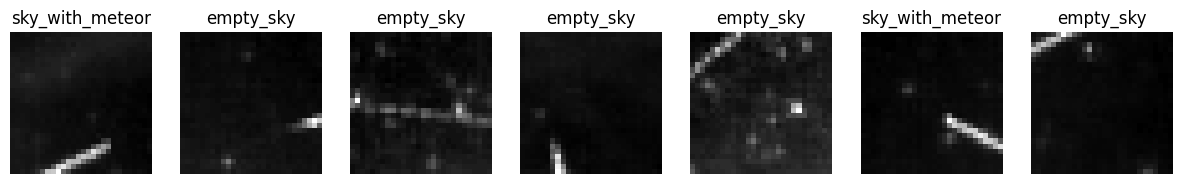

In [71]:
# Faça a inferência em uma imagem de exemplo

import os
from PIL import Image
import matplotlib.pyplot as plt
import os
import random

# Especifica o caminho para a pasta com os arquivos .pg
folder_path = './classes/sky_with_meteor/'

# Obtém uma lista com o nome de todos os arquivos na pasta
file_list = random.sample(os.listdir(folder_path), k=7)

# Cria uma figura com subplots para cada imagem
fig, axs = plt.subplots(1, len(file_list), figsize=(15, 5))

# Itera sobre cada arquivo na lista
for i, file_name in enumerate(file_list):
    # Verifica se o arquivo tem a extensão .pg
    if file_name.endswith('.png'):
        # Abre o arquivo com a biblioteca PIL
        file_path = os.path.join(folder_path, file_name)
        image = Image.open(file_path)
        
        # Aplica as transformações na imagem
        image = transform(image).to(device)

        # Faça a inferência na rede neural na imagem de exemplo
        model_mlp.eval()
        with torch.no_grad():
            output = model_mlp(image.unsqueeze(0))
            _, predicted = torch.max(output, 1)

        # Exiba a classe predita pela rede neural
        axs[i].imshow(image.cpu().detach().squeeze(), cmap='gray')
        axs[i].set_title(dataset.classes[predicted])
        axs[i].axis('off')
plt.show()

É importante ressaltar que, apesar da alta taxa de precisão, o modelo ainda apresenta algumas falhas na classificação de alguns casos. Isso pode ser devido às características específicas das imagens em questão, que podem ser difíceis de serem detectadas pelo modelo. Talvez seja necessário adaptar o modelo para melhorar sua capacidade de lidar com essas imagens específicas. No entanto, uma coisa que tenho certeza é que é fundamental aumentar a quantidade de dados disponíveis para treinamento do modelo, de forma a fornecer uma base mais robusta para identificação de características e melhorar sua capacidade de diferenciação entre as classes.

### Conclusões


Criar um modelo como este, com a propósito que tem, é sem dúvidas desafiador, do início ao fim. No entanto, para mim, isso é um gatilho motivacional. As horas de pesquisa e experimentação aplicadas aqui me fizeram ter uma compreensão melhor sobre como funciona a dinâmica deste tipo de modelo de classificação de imagens e me impuseram lidar com desafios além dos apresentados aqui, como o armazenamento dos dados e preprocessamento. Tudo desenvolvido aqui foi feito com muito esforço, dedicação e, principalmente, entusiasmo e amor. Eu realmente gosto disso.

Irei continuar aprimorando este modelo, principalmente rotulando mais dados e mesclando este meu hobby com a área de estudo que pretendo seguir. Por agora é isso, espero que tenha gostado do artigo. Compartilhe com seus conhecidos e, como de praxe, tudo desenvolvido aqui estará em meu GitHub, que neste caso, é o repositório Vega. Fui!

### Bônus de código 

Salvando os modelos

In [74]:
torch.save(model_cae.state_dict(), 'model_cae.pth')
torch.save(model_mlp.state_dict(), 'model_mlp.pth')

Carregando modelo

In [75]:
model_cae.load_state_dict(torch.load('model_cae.pth'))
model_mlp.load_state_dict(torch.load('model_mlp.pth'))

<All keys matched successfully>

*Gostaria de fazer a referência deste texto em um trabalho escolar ou acadêmico? Use:*

RUAS, Isak Paulo de Andrade. Treinando minha rede neural de detecção de meteoros. 2023. Disponível em: https://3devs.com.br/post/6/. Acesso em: Dia Mês. Ano.